# MSIT 3103 — Assignment 4 Hotstart Notebook
**Comparative Analysis of Training Methods (5%)**  
**Due:** End of Week 5  
**CLO3:** Compare and evaluate different training methodologies used in generative AI models.

This notebook gives you a simple, compact scaffold so you can **experiment quickly** while keeping your work **well-structured and comparable**. You’ll train the **same tiny generative model** with three methods:

1. **Pre-training (Unsupervised LM)**
2. **Supervised Fine-Tuning (SFT)**
3. **(Bonus) Reinforcement Learning (RL-lite)** — toy REINFORCE with a simple reward

You will:
- Run short training loops on tiny data to **see the dynamics**, not to hit SOTA.
- Use helper utilities to **measure perplexity**, sample generations, and **plot losses**.
- Fill in the **Results & Discussion** cells with your observations.

> ⚠️ The defaults are intentionally tiny (fast, CPU-friendly). Scale up **only if your machine can handle it**.


# Report Questions (Answer in your 2–5 page PDF)

### 1. Introduction (Objectives & Rationale)
1. What training methods are you comparing in this assignment?  
2. Why did you choose these methods and settings?  
3. Were there any hardware or time constraints that influenced your choices?  

### 2. Methods
4. What dataset did you use (corpus size, preprocessing steps, train/validation split)?  
5. What is the architecture of your model (layers, hidden size, heads, parameters)?  
6. How did you train your models (steps, batch size, learning rate, optimizer)?  
7. For SFT: How did you construct or curate your instruction–answer pairs?  
8. For RL-lite: What reward function did you design and why?  

### 3. Results
9. What do your loss curves show for pre-training vs. SFT?  
10. How do the perplexity scores compare across methods?  
11. How do BLEU scores differ for the instruction prompts?  
12. How do sample outputs change before SFT, after SFT, and after RL-lite? Provide examples.  

### 4. Discussion
13. How stable was the training process (convergence, fluctuations, instabilities)?  
14. What transfer effects did you observe from pre-training to SFT?  
15. What were the strengths and weaknesses of your RL-lite approach?  
16. What were the main costs in terms of resources and time? If you scaled up, what would you change next?  

### 5. Conclusion
17. What are your key insights from comparing these training methods?  
18. What practical recommendations would you make for someone building generative AI models based on your experiments?  

## [Bonus] RL-lite with REINFORCE (Optional)
**Toy** example: optimize the model to include a **keyword** in the completion and keep length near a **target**.



In [2]:
!pip install ipykernel


## 0. Environment Setup (Run Once)
If you are running locally and missing packages, uncomment the `pip` cell below.

- Python ≥ 3.9
- `torch`, `numpy`, `matplotlib`, `tqdm`, `nltk`, `pandas` (optional: `datasets` for WikiText-2)


In [3]:
# If needed, uncomment to install.
%pip install torch numpy matplotlib tqdm nltk pandas datasets --quiet

import math
import os
import random
import time
import json
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt
import pandas as pd

import nltk
try:
    nltk.data.find("tokenizers/punkt")
except LookupError:
    nltk.download("punkt")

Note: you may need to restart the kernel to use updated packages.


## 1. Config

In [4]:
from dataclasses import dataclass
@dataclass
class Config:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    # data
    use_builtin_tiny_corpus: bool = True  # if False, tries tiny wikitext-2 via datasets
    context_len: int = 64
    train_frac: float = 0.9
    # model
    vocab_size: int = 0  # filled after building tokenizer
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 2
    dropout: float = 0.1
    # optimization
    batch_size: int = 64
    lr: float = 3e-3
    max_steps_pretrain: int = 1000
    max_steps_sft: int = 1000
    max_steps_rl: int = 200  # tiny on purpose
    eval_every: int = 50
    # generation
    temperature: float = 0.7
    top_k: Optional[int] = 50

CFG = Config()
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CFG.seed)

CFG.device

'cpu'

## 2. Data: Tiny Corpus + Optional Synthetic
We use a tiny **public-domain** text for **pre-training** and **validation**.  
For **SFT**, we create a micro instruction-like dataset.

You can switch to `datasets` (WikiText-2) by setting `CFG.use_builtin_tiny_corpus=False`.


### Tried with WikiText : wikitext-103-raw-v1  , got this reference from Hugging Face

In [5]:
BUILTIN_TINY_TEXT = "From fairest creatures we desire increase,\nThat thereby beauty's rose might never die,\nBut as the riper should by time decease,\nHis tender heir might bear his memory:\nBut thou contracted to thine own bright eyes,\nFeed'st thy light'st flame with self-substantial fuel,\nMaking a famine where abundance lies,\nThy self thy foe, to thy sweet self too cruel:"

def load_corpus(use_builtin: bool = False) -> str:
    """Return a small training corpus."""
    if use_builtin:
        return BUILTIN_TINY_TEXT.strip()
    else:
        try:
            from datasets import load_dataset
            ds = load_dataset("wikitext", "wikitext-2-raw-v1")
            # concatenate first N lines to keep it tiny
            lines = ds['train']['text'][:200]
            return "\n".join([l for l in lines if l is not None]).strip()
        except Exception as e:
            print("Falling back to builtin tiny text due to:", e)
            return BUILTIN_TINY_TEXT.strip()

#corpus_text = load_corpus(use_builtin = True)
corpus_text = load_corpus(use_builtin = False)

print(corpus_text[:5000], "...")

c:\Users\PuttarajuS\Desktop\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


= Valkyria Chronicles III = 


 Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 

 The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for series ne

### 2.1 Character Tokenizer
A simple **character-level** tokenizer

In [7]:
class CharTokenizer:
    def __init__(self, text: str):
        vocab = sorted(set(text))
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for ch, i in self.stoi.items()}
        self.vocab_size = len(vocab)

    def encode(self, s: str) -> List[int]:
        return [self.stoi[c] for c in s if c in self.stoi]

    def decode(self, ids: List[int]) -> str:
        return "".join(self.itos[i] for i in ids)

tokenizer = CharTokenizer(corpus_text[:200])
CFG.vocab_size = tokenizer.vocab_size
print(f"CFG.vocab_size: {CFG.vocab_size}")

# Update the top_k based on vocab size
CFG.top_k = min(50, CFG.vocab_size) # ensure top_k is not greater than vocab_size
print(f"CFG.top_k: {CFG.top_k}")
print(tokenizer)
print(CFG.device)
print(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len)
print(CFG.max_steps_pretrain)
print(CFG.max_steps_sft)
#print(corpus_text)

CFG.vocab_size: 46
CFG.top_k: 46
cpu
46 128 2 4 0.1 64
1000
1000


### 2.2 Dataset & DataLoader
We build tiny (input, target) pairs for next-char prediction.

In [9]:
class LMDataset(Dataset):
    def __init__(self, text: str, tokenizer: CharTokenizer, context_len: int = 64, split: str = "train", train_frac: float = 0.9):
        enc = tokenizer.encode(text)
        n = int(len(enc) * train_frac)
        if split == "train":
            self.data = enc[:n]
        else:
            self.data = enc[n:]
        self.context_len = context_len

    def __len__(self):
        return max(0, len(self.data) - self.context_len - 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.context_len]
        y = self.data[idx+1:idx+self.context_len+1]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

train_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "train", CFG.train_frac)
val_ds = LMDataset(corpus_text, tokenizer, CFG.context_len, "val", CFG.train_frac)

train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

len(train_ds), len(val_ds)
print(train_ds, val_ds)
print(train_loader, val_loader)


<__main__.LMDataset object at 0x000001C3DB45C680> <__main__.LMDataset object at 0x000001C3DA46BB00>
<torch.utils.data.dataloader.DataLoader object at 0x000001C3DA640260> <torch.utils.data.dataloader.DataLoader object at 0x000001C3DB40F3B0>


## 3. Model: Tiny GPT-like (Character-level)
Small causal self-attention stack for quick experiments.

In [11]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(context_len, context_len)).unsqueeze(0).unsqueeze(0))

    def forward(self, x):
        B, T, C = x.shape
        qkv = self.qkv(x)
        q, k, v = qkv.split(C, dim=2)
        q = q.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)  # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v  # (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, d_model, n_heads, dropout, context_len):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.attn = CausalSelfAttention(d_model, n_heads, dropout, context_len)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, dropout, context_len):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Parameter(torch.zeros(1, context_len, d_model))
        self.blocks = nn.ModuleList([Block(d_model, n_heads, dropout, context_len) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)

        # init
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        x = self.tok_emb(idx) + self.pos_emb[:, :T, :]
        for blk in self.blocks:
            x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, V)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens=128, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -CFG.context_len:]
            logits, _ = self.forward(idx_cond)
            logits = logits[:, -1, :] / max(temperature, 1e-8)
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                mask = logits < v[:, [-1]]
                logits[mask] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            next_id = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx

print(CFG.vocab_size)    
print(CFG.d_model, CFG.n_heads, CFG.n_layers)
print(CFG.max_steps_sft)
print(nn.Module)



46
128 4 2
1000
<class 'torch.nn.modules.module.Module'>


## 4. Utilities: Evaluation & Plotting

In [15]:
def eval_loss(model, loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            _, loss = model(x, y)
            losses.append(loss.item())
    model.train()
    return float(np.mean(losses)) if losses else float('nan')

def perplexity(loss_val: float) -> float:
    try:
        return float(math.exp(loss_val))
    except OverflowError:
        return float('inf')

def sample_text(model, prompt: str, max_new_tokens=128):
    model.eval()
    inp = torch.tensor([tokenizer.encode(prompt)], dtype=torch.long, device=CFG.device)
    out = model.generate(inp, max_new_tokens=max_new_tokens, temperature=CFG.temperature, top_k=CFG.top_k)
    return tokenizer.decode(out[0].tolist())

def plot_losses(train_losses, val_losses, title="Training Curves"):
    plt.figure()
    xs = list(range(len(train_losses)))
    plt.plot(xs, train_losses, label="train")
    if val_losses:
        plt.plot(xs, val_losses, label="val")
    plt.title(title)
    plt.xlabel("Eval step (x{} steps)".format(CFG.eval_every))
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## 5. Pre-training (Unsupervised LM)
Train the tiny GPT on the tiny corpus with next-character prediction.

Pre-training:   0%|          | 0/1000 [04:15<?, ?it/s, loss=1.53, val_loss=1.91]

Pre-train done. Train loss ~ 1.5341171026229858  Val loss ~ 1.907128948669929  PPL ~ 6.7337281399754785


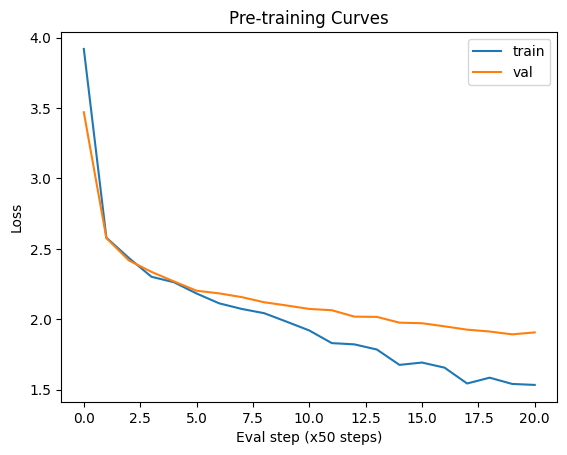

o eameless and the Camden the city en the amelesse teen ame , aaf the surrender . 

 he park sechanin caused , e sere the f


In [16]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
CFG.max_steps_pretrain = 1000
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))


#### zero_grad(set_to_none=False) 

Pre-training:   0%|          | 0/1000 [05:05<?, ?it/s, loss=1.53, val_loss=1.9] 

Pre-train done. Train loss ~ 1.526641607284546  Val loss ~ 1.8990268428604324  PPL ~ 6.679391181229065


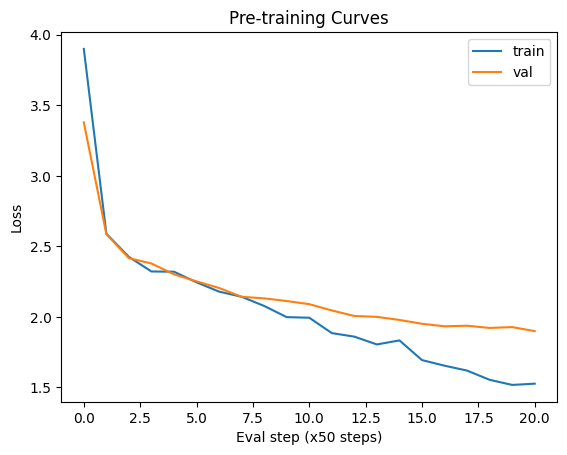

o ere the ork seer , and and ith pulayin orlation armed ake in a ame Japanese in theme he cou uilder , and it the ame s yim


In [17]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=False)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))

Pre-training:   0%|          | 0/1000 [03:31<?, ?it/s, loss=1.54, val_loss=1.98]

Pre-train done. Train loss ~ 1.541245698928833  Val loss ~ 1.9787423105800852  PPL ~ 7.23363958975942


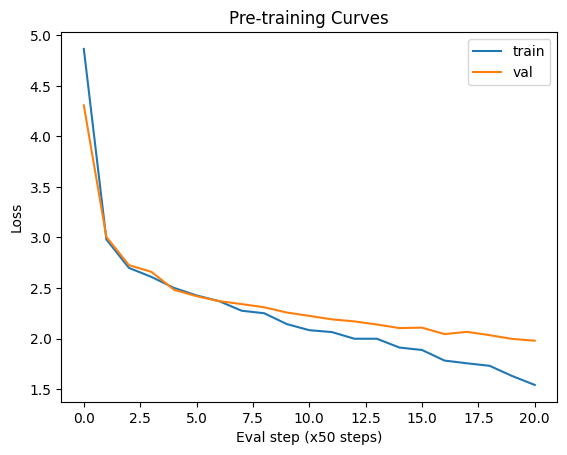

To befor boxis , " Work Potention ho , and " Elachy Ellet . 

 Lthe exervies alone paymer , what a the Calaydelen Portently m


In [17]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=False)
        loss.backward()
        opt.step(closure=None)
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))

Pre-training:   0%|          | 0/500 [01:26<?, ?it/s, loss=1.94, val_loss=2.07]

Pre-train done. Train loss ~ 1.9438457489013672  Val loss ~ 2.074844764424609  PPL ~ 7.963310174042665


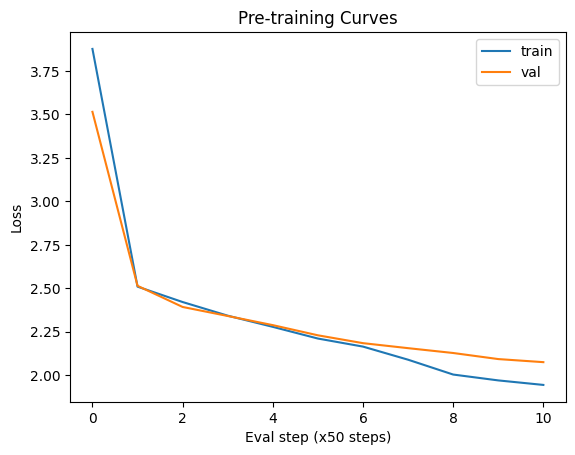

o ead of arate of sumild houht and that ajut to at unnt  for Conil andl ue in . he ado enoer for S aposeraly of the sith of


In [18]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
CFG.max_steps_pretrain = 500
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))


Pre-training:   0%|          | 0/100 [00:29<?, ?it/s, loss=2.7, val_loss=2.74] 


Pre-train done. Train loss ~ 2.703731060028076  Val loss ~ 2.7383178240293033  PPL ~ 15.460955161755683


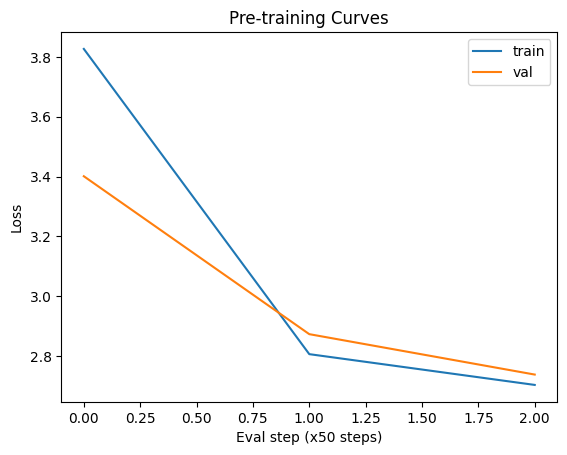

o e lte it ltoe tooae optop atee .e s . ss ne aa  n octrre rthe ce yyle td oc, he p
 ,iae e a otk fcly in hoae reydtoiald f


In [19]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
CFG.max_steps_pretrain = 100
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=False)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))

Pre-training:   0%|          | 0/250 [00:42<?, ?it/s, loss=2.25, val_loss=2.28]

Pre-train done. Train loss ~ 2.251474618911743  Val loss ~ 2.2797663831091546  PPL ~ 9.774396678618286


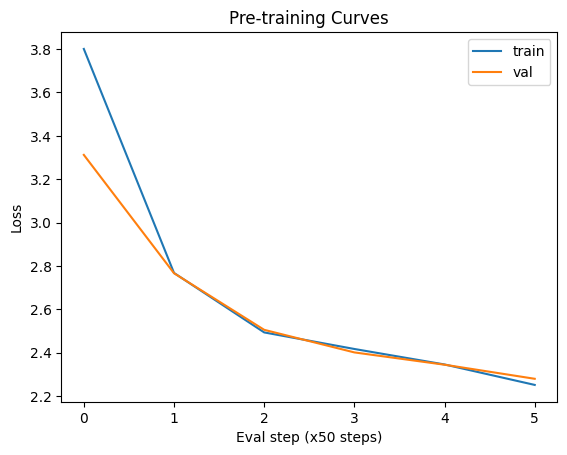

o ethare chund aly ad id atath and . Be  in pat in in an therin he , as 
Sins ans tacry denantesis tos orm iath ary dela ul


In [20]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
CFG.max_steps_pretrain = 250
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=False)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))











Pre-training:   0%|          | 0/400 [01:01<?, ?it/s, loss=2.14, val_loss=2.19]

Pre-train done. Train loss ~ 2.142359733581543  Val loss ~ 2.191261641390912  PPL ~ 8.946493263656027


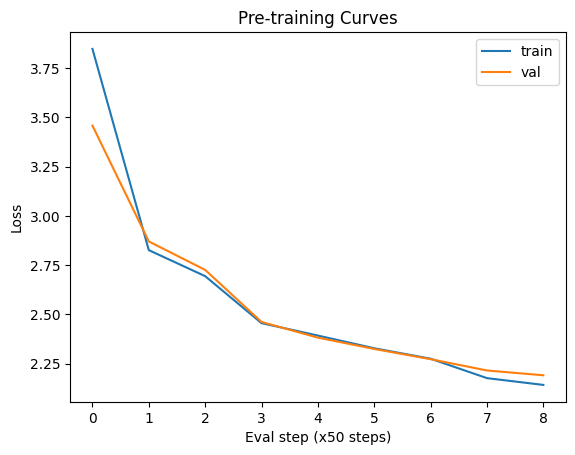

o eder .  euil Carile the enad e imich ile and , der , piitay of reposy of ocontin alil plicien 3 n cece orde mile intis po


In [145]:
model_pre = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
opt = torch.optim.AdamW(model_pre.parameters(), lr=CFG.lr)

train_losses_pre, val_losses_pre = [], []
step = 0
CFG.max_steps_pretrain = 400
pbar = tqdm(total=CFG.max_steps_pretrain, desc="Pre-training")

while step < CFG.max_steps_pretrain:
    for x, y in train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_pre(x, y)
        opt.zero_grad(set_to_none=False)
        loss.backward()
        opt.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_pre, val_loader)
            train_losses_pre.append(loss.item())
            val_losses_pre.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_pretrain:
            break
pbar.close()

pt_train_last = train_losses_pre[-1] if train_losses_pre else float('nan')
pt_val_last = val_losses_pre[-1] if val_losses_pre else float('nan')
print("Pre-train done. Train loss ~", pt_train_last, " Val loss ~", pt_val_last, " PPL ~", perplexity(pt_val_last))
plot_losses(train_losses_pre, val_losses_pre, title="Pre-training Curves")
print(sample_text(model_pre, prompt="To be", max_new_tokens=120))

## 6. Supervised Fine-Tuning (SFT)
We create a **tiny instruction-like dataset** of (prompt → completion).  
We then **continue training** the pre-trained model on these pairs (next-token loss).

Instruction: Define overfitting in one sentence:
Answer: When a model memorizes training data but fails to generalize.

Instruction: Give a positive morning affirmation:
Answer: Today I choose growth and gratitude.

Instruction: Summarize: 'Data is the new oil'.
Answer: Data fuels innovation like oil powered industries.

Instruction: Write a short motto about teamwork:
Answer: Together everyone achieves more.

Instruction: Explain: What is gradient descent?
Answer: An algorithm to minimize loss by updating weights step by step.

Instruction: Give a fun tagline for a library:
Answer: Unlock worlds, one page at a time.

Instruction: Summarize the role of attention in transformers.
Answer: Attention lets the model focus on relevant parts of input.

Instruction: Create a motto about perseverance:
Answer: Keep going, keep growing.

Instruction: Explain dropout in deep learning (short):
Answer: A regularization technique that randomly ignores neurons during training.

Instruction: Write a sh

SFT:   0%|          | 0/1000 [04:31<?, ?it/s, loss=0.108, val_loss=0.501]

SFT done. Train loss ~ 0.10794267803430557  Val loss ~ 0.501333628914186  PPL ~ 1.6509215198900289


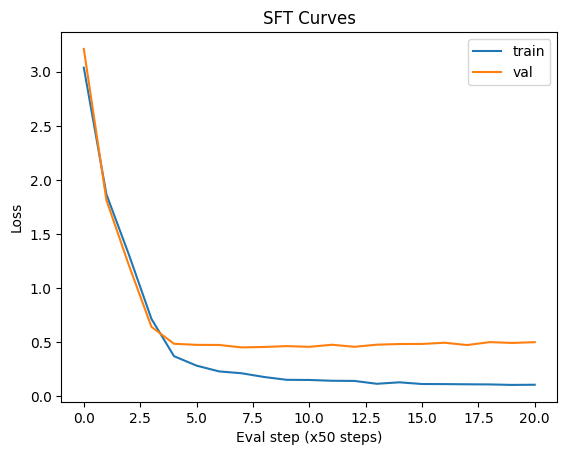

Sample before SFT (pretrained):
Instruction: Summarie the role of attention in transformers.
nser: i cren he mee the as den s arin  aes hert  elop  he is hia in colatrin the tla ryer sioit th rancas srenptun alltont at

Sample after SFT:
Instruction: Summarie the role of attention in transformers.
nser: ttention lets the model focus on releant parts of input.

Instruction: Create a motto aout perseerance:
nser: eep oin, 


In [21]:
SFT_PAIRS = [
    ("Define overfitting in one sentence:", " When a model memorizes training data but fails to generalize."),
    ("Give a positive morning affirmation:", " Today I choose growth and gratitude."),
    ("Summarize: 'Data is the new oil'.", " Data fuels innovation like oil powered industries."),
    ("Write a short motto about teamwork:", " Together everyone achieves more."),
    ("Explain: What is gradient descent?", " An algorithm to minimize loss by updating weights step by step."),
    ("Give a fun tagline for a library:", " Unlock worlds, one page at a time."),
    ("Summarize the role of attention in transformers.", " Attention lets the model focus on relevant parts of input."),
    ("Create a motto about perseverance:", " Keep going, keep growing."),
    ("Explain dropout in deep learning (short):", " A regularization technique that randomly ignores neurons during training."),
    ("Write a short motto about creativity:", " Imagine more. Create more."),
    ("Summarize: 'Cloud computing advantage'.", " It offers scalability, flexibility, and lower upfront costs."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    # Concatenate as instruction blocks to make conditional LM easy
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print(sft_text)

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.1)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

print(CFG.max_steps_sft)
# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
CFG.max_steps_sft=1000
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

print("Sample before SFT (pretrained):")
print(sample_text(model_pre, prompt="Instruction: Summarize the role of attention in transformers.\nAnswer:", max_new_tokens=120))

print("\nSample after SFT:")
print(sample_text(model_sft, prompt="Instruction: Summarize the role of attention in transformers.\nAnswer:", max_new_tokens=120))


Instruction: Define overfitting in one sentence:
Answer: When a model memorizes training data but fails to generalize.

Instruction: Give a positive morning affirmation:
Answer: Today I choose growth and gratitude.

Instruction: Summarize: 'Data is the new oil'.
Answer: Data fuels innovation like oil powered industries.

Instruction: Write a short motto about teamwork:
Answer: Together everyone achieves more.

Instruction: Explain: What is gradient descent?
Answer: An algorithm to minimize loss by updating weights step by step.

Instruction: Give a fun tagline for a library:
Answer: Unlock worlds, one page at a time.

Instruction: Summarize the role of attention in transformers.
Answer: Attention lets the model focus on relevant parts of input.

Instruction: Create a motto about perseverance:
Answer: Keep going, keep growing.

Instruction: Explain dropout in deep learning (short):
Answer: A regularization technique that randomly ignores neurons during training.

Instruction: Write a sh

SFT:   0%|          | 0/300 [00:00<?, ?it/s]

SFT:   0%|          | 0/300 [00:53<?, ?it/s, loss=0.236, val_loss=0.494]

SFT done. Train loss ~ 0.23565343022346497  Val loss ~ 0.4939433192568166  PPL ~ 1.6387656717050965


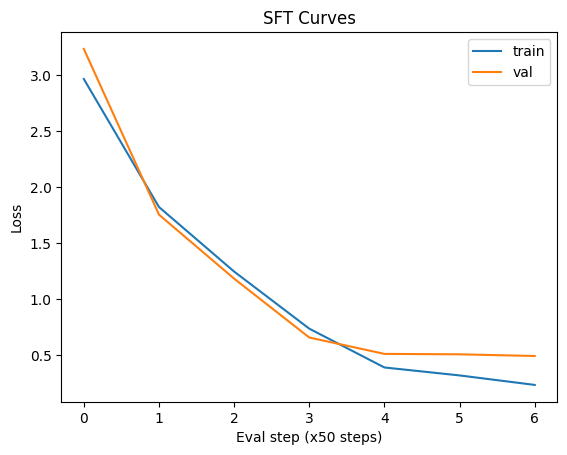

Sample before SFT (pretrained):
Instruction: Summarie the role of attention in transformers.
nser: aro in che is th he inas  




 cen s  dhe = I 
 und =  








 pary  stis 3 

 maled s hes ith ulon = the uthe aros 

Sample after SFT:
Instruction: Summarie the role of attention in transformers.
nser: tttention lets the model focus on releant parts of input.

Instruction: Create a motto aout perseerance:
nser: eeep oin


In [22]:
SFT_PAIRS = [
    ("Define overfitting in one sentence:", " When a model memorizes training data but fails to generalize."),
    ("Give a positive morning affirmation:", " Today I choose growth and gratitude."),
    ("Summarize: 'Data is the new oil'.", " Data fuels innovation like oil powered industries."),
    ("Write a short motto about teamwork:", " Together everyone achieves more."),
    ("Explain: What is gradient descent?", " An algorithm to minimize loss by updating weights step by step."),
    ("Give a fun tagline for a library:", " Unlock worlds, one page at a time."),
    ("Summarize the role of attention in transformers.", " Attention lets the model focus on relevant parts of input."),
    ("Create a motto about perseverance:", " Keep going, keep growing."),
    ("Explain dropout in deep learning (short):", " A regularization technique that randomly ignores neurons during training."),
    ("Write a short motto about creativity:", " Imagine more. Create more."),
    ("Summarize: 'Cloud computing advantage'.", " It offers scalability, flexibility, and lower upfront costs."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    # Concatenate as instruction blocks to make conditional LM easy
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print(sft_text)

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.1)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

print(CFG.max_steps_sft)
# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
CFG.max_steps_sft=300
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

print("Sample before SFT (pretrained):")
print(sample_text(model_pre, prompt="Instruction: Summarize the role of attention in transformers.\nAnswer:", max_new_tokens=120))

print("\nSample after SFT:")
print(sample_text(model_sft, prompt="Instruction: Summarize the role of attention in transformers.\nAnswer:", max_new_tokens=120))


Instruction: Write a short motto about learning:
Answer: Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'.
Answer: They learn patterns by adjusting weights.

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)?
Answer: A measure of how well a language model predicts a sample.




SFT:   0%|          | 0/500 [00:00<?, ?it/s]

SFT:   0%|          | 0/500 [01:16<?, ?it/s, loss=0.0848, val_loss=0.506]

SFT done. Train loss ~ 0.08479724079370499  Val loss ~ 0.50568712875247  PPL ~ 1.6581244741134744


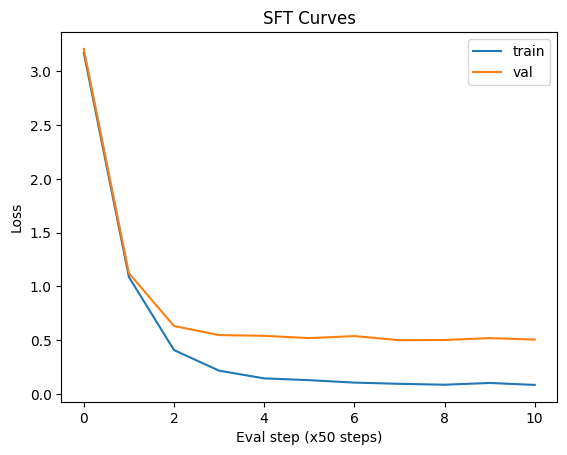

Sample before SFT (pretrained):
Instruction: ie a creatie taline for coffee:
nser: aled hurin timed 










 ith ariche aritom lorenid aarin fre in e In 
 ary he hothe e  ather toche in che Sthe or t

Sample after SFT:
Instruction: ie a creatie taline for coffee:
nser: Sip ideas. Bre rilliance.

I


In [23]:
SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    # Concatenate as instruction blocks to make conditional LM easy
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print(sft_text)

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.1)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
CFG.max_steps_sft=500
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

print("Sample before SFT (pretrained):")
print(sample_text(model_pre, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=120))

print("\nSample after SFT:")
print(sample_text(model_sft, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=29))


Instruction: Write a short motto about learning:
Answer: Learn, iterate, and grow.

Instruction: Summarize: 'Neural nets learn patterns'.
Answer: They learn patterns by adjusting weights.

Instruction: Give a creative tagline for coffee:
Answer: Sip ideas. Brew brilliance.

Instruction: Explain: What is perplexity (1 sentence)?
Answer: A measure of how well a language model predicts a sample.




SFT:   0%|          | 0/100 [00:00<?, ?it/s]

SFT:   0%|          | 0/100 [00:15<?, ?it/s, loss=0.389, val_loss=0.582]

SFT done. Train loss ~ 0.3892156481742859  Val loss ~ 0.5818449072539806  PPL ~ 1.7893365474310685


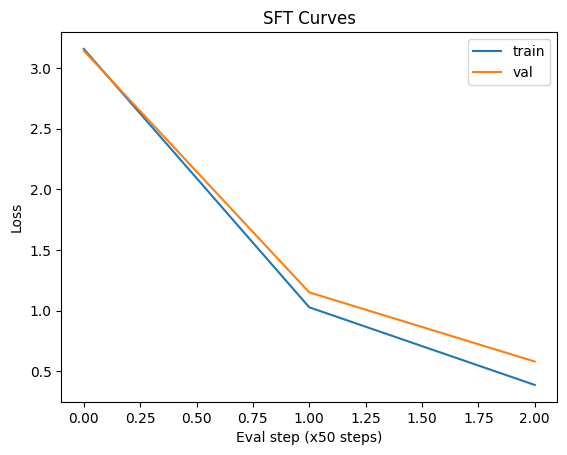

Sample before SFT (pretrained):
Instruction: ie a creatie taline for coffee:
nser: s ran hermin  = a Bas Sith arkin is (  anand I 



 Ustin alsind a he 

 


 toelin 


 the de uaer pror aor the and fr

Sample after SFT:
Instruction: ie a creatie taline for coffee:
nser: Sip ideas. Bre rilliance.

I


In [24]:
SFT_PAIRS = [
    ("Write a short motto about learning:", " Learn, iterate, and grow."),
    ("Summarize: 'Neural nets learn patterns'.", " They learn patterns by adjusting weights."),
    ("Give a creative tagline for coffee:", " Sip ideas. Brew brilliance."),
    ("Explain: What is perplexity (1 sentence)?", " A measure of how well a language model predicts a sample."),
]

def build_sft_text(pairs: List[Tuple[str, str]]) -> str:
    # Concatenate as instruction blocks to make conditional LM easy
    blocks = []
    for inp, out in pairs:
        blocks.append(f"Instruction: {inp}\nAnswer:{out}\n\n")
    return "".join(blocks)

sft_text = build_sft_text(SFT_PAIRS)
print(sft_text)

# Build tiny SFT dataset as LM on the concatenated text
sft_train_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "train", 0.9)
sft_val_ds = LMDataset(sft_text, tokenizer, CFG.context_len, "val", 0.1)
sft_train_loader = DataLoader(sft_train_ds, batch_size=CFG.batch_size, shuffle=True, drop_last=True)
sft_val_loader = DataLoader(sft_val_ds, batch_size=CFG.batch_size, shuffle=False, drop_last=True)

# Copy the pre-trained model weights
model_sft = TinyGPT(CFG.vocab_size, CFG.d_model, CFG.n_layers, CFG.n_heads, CFG.dropout, CFG.context_len).to(CFG.device)
model_sft.load_state_dict(model_pre.state_dict())
opt_sft = torch.optim.AdamW(model_sft.parameters(), lr=CFG.lr)

train_losses_sft, val_losses_sft = [], []
step = 0
CFG.max_steps_sft=100
pbar = tqdm(total=CFG.max_steps_sft, desc="SFT")

while step < CFG.max_steps_sft:
    for x, y in sft_train_loader:
        x, y = x.to(CFG.device), y.to(CFG.device)
        _, loss = model_sft(x, y)
        opt_sft.zero_grad(set_to_none=True)
        loss.backward()
        opt_sft.step()
        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            vl = eval_loss(model_sft, sft_val_loader)
            train_losses_sft.append(loss.item())
            val_losses_sft.append(vl)
            pbar.set_postfix(loss=loss.item(), val_loss=vl)

        if step >= CFG.max_steps_sft:
            break
pbar.close()

sft_train_last = train_losses_sft[-1] if train_losses_sft else float('nan')
sft_val_last = val_losses_sft[-1] if val_losses_sft else float('nan')
print("SFT done. Train loss ~", sft_train_last, " Val loss ~", sft_val_last, " PPL ~", perplexity(sft_val_last))
plot_losses(train_losses_sft, val_losses_sft, title="SFT Curves")

print("Sample before SFT (pretrained):")
print(sample_text(model_pre, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=120))

print("\nSample after SFT:")
print(sample_text(model_sft, prompt="Instruction: Give a creative tagline for coffee:\nAnswer:", max_new_tokens=29))

# Reinforcement Learning using SFT Dataset

In [141]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Copy weights from SFT (supervised) model
model_rl = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers,
    CFG.n_heads, CFG.dropout, CFG.context_len
).to(CFG.device)
model_rl.load_state_dict(model_sft.state_dict())

opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr)

# ----------------------------
# Define Reward Function
# ----------------------------
def reward_function(generated_text: str, reference: str = None) -> float:
    """
    Very simple reward. You can replace with BLEU, ROUGE,
    toxicity filters, or task-specific score.
    """
    # Example: reward if keyword "learning" appears
    reward = 1.0 if "learning" in generated_text.lower() else 0.0
    
    # Bonus: length penalty (keep within 20–50 tokens)
    length_penalty = -abs(len(generated_text.split()) - 30) / 30.0
    return reward + length_penalty

# ----------------------------
# RL Training Loop (REINFORCE)
# ----------------------------
train_rewards, val_rewards = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_rl, desc="RL-lite (REINFORCE)")

while step < CFG.max_steps_rl:
    for batch in sft_train_loader:  # reuse instruction dataset
        x, _ = batch
        x = x.to(CFG.device)

        # 1. Sample text from model (policy)
        prompt = tokenizer.decode(x[0].tolist())  # take one prompt
        gen_text = sample_text(model_rl, prompt=prompt, max_new_tokens=50)

        # 2. Compute reward
        R = reward_function(gen_text)

        # 3. Compute log-probabilities of sampled tokens
        #tokens = torch.tensor([tokenizer.encode(gen_text)], dtype=torch.long, device=CFG.device)
        token_ids = tokenizer.encode(gen_text)[:CFG.context_len] 
        tokens = torch.tensor([token_ids], dtype=torch.long, device=CFG.device)
        logits, _ = model_rl(tokens[:, :-1], tokens[:, 1:])
        log_probs = torch.log_softmax(logits, dim=-1)

        # Gather log-probs of the actual sampled sequence
        chosen_log_probs = log_probs.gather(
            2, tokens[:, 1:].unsqueeze(-1)
        ).squeeze(-1).mean()

        # 4. Policy gradient loss = -R * log_prob
        loss = -R * chosen_log_probs

        # 5. Optimize
        opt_rl.zero_grad()
        loss.backward()
        opt_rl.step()

        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            train_rewards.append(R)
            avg_reward = sum(train_rewards[-10:]) / min(len(train_rewards), 10)
            pbar.set_postfix(loss=loss.item(), reward=R, avg_reward=avg_reward)

        if step >= CFG.max_steps_rl:
            break
pbar.close()

print("RL-lite training done. Avg reward ~", sum(train_rewards) / len(train_rewards))
print("Sample after RL training:")
print(sample_text(model_rl, prompt="Instruction: Write a short motto about learning:\nAnswer:", max_new_tokens=60))










































RL-lite (REINFORCE):   0%|          | 0/2000 [06:01<?, ?it/s, avg_reward=-0.647, loss=-2.5e+4, reward=-0.667]


RL-lite training done. Avg reward ~ -0.6471544715447154
Sample after RL training:
Instruction: rite a short motto aout learnin:
nser:IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII


### Reinforcement Learning using Pretraining Dataset

In [127]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Copy weights from SFT (supervised) model
model_rl = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers,
    CFG.n_heads, CFG.dropout, CFG.context_len
).to(CFG.device)
model_rl.load_state_dict(model_pre.state_dict())

opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr)

# ----------------------------
# Define Reward Function
# ----------------------------
def reward_function(generated_text: str, reference: str = None) -> float:
    """
    Very simple reward. You can replace with BLEU, ROUGE,
    toxicity filters, or task-specific score.
    """
    # Example: reward if keyword "learning" appears
    reward = 1.0 if "learning" in generated_text.lower() else 0.0
    
    # Bonus: length penalty (keep within 20–50 tokens)
    length_penalty = -abs(len(generated_text.split()) - 30) / 30.0
    return reward + length_penalty

# ----------------------------
# RL Training Loop (REINFORCE)
# ----------------------------
train_rewards, val_rewards = [], []
step = 0
pbar = tqdm(total=CFG.max_steps_rl, desc="RL-lite (REINFORCE)")

while step < CFG.max_steps_rl:
    for batch in sft_train_loader:  # reuse instruction dataset
        x, _ = batch
        x = x.to(CFG.device)

        # 1. Sample text from model (policy)
        prompt = tokenizer.decode(x[0].tolist())  # take one prompt
        gen_text = sample_text(model_rl, prompt=prompt, max_new_tokens=50)

        # 2. Compute reward
        R = reward_function(gen_text)

        # 3. Compute log-probabilities of sampled tokens
        #tokens = torch.tensor([tokenizer.encode(gen_text)], dtype=torch.long, device=CFG.device)
        token_ids = tokenizer.encode(gen_text)[:CFG.context_len] 
        tokens = torch.tensor([token_ids], dtype=torch.long, device=CFG.device)
        logits, _ = model_rl(tokens[:, :-1], tokens[:, 1:])
        log_probs = torch.log_softmax(logits, dim=-1)

        # Gather log-probs of the actual sampled sequence
        chosen_log_probs = log_probs.gather(
            2, tokens[:, 1:].unsqueeze(-1)
        ).squeeze(-1).mean()

        # 4. Policy gradient loss = -R * log_prob
        loss = -R * chosen_log_probs

        # 5. Optimize
        opt_rl.zero_grad()
        loss.backward()
        opt_rl.step()

        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            train_rewards.append(R)
            avg_reward = sum(train_rewards[-10:]) / min(len(train_rewards), 10)
            pbar.set_postfix(loss=loss.item(), reward=R, avg_reward=avg_reward)

        if step >= CFG.max_steps_rl:
            break
pbar.close()

print("RL-lite training done. Avg reward ~", sum(train_rewards) / len(train_rewards))
print("Sample after RL training:")
#print(sample_text(model_rl, prompt="Instruction: Write a short motto about learning:\nAnswer:", max_new_tokens=60))
print(sample_text(model_rl, prompt="To be", max_new_tokens=120))


RL-lite (REINFORCE):   0%|          | 0/200 [00:29<?, ?it/s, avg_reward=-0.6, loss=-336, reward=-0.667]   


RL-lite training done. Avg reward ~ -0.6
Sample after RL training:
o e                                                                                                                        


In [130]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Copy weights from SFT (supervised) model
model_rl = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers,
    CFG.n_heads, CFG.dropout, CFG.context_len
).to(CFG.device)
model_rl.load_state_dict(model_pre.state_dict())

opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr)

# ----------------------------
# Define Reward Function
# ----------------------------
def reward_function(generated_text: str, reference: str = None) -> float:
    """
    Very simple reward. You can replace with BLEU, ROUGE,
    toxicity filters, or task-specific score.
    """
    # Example: reward if keyword "learning" appears
    reward = 1.0 if "learning" in generated_text.lower() else 0.0
    
    # Bonus: length penalty (keep within 20–50 tokens)
    length_penalty = -abs(len(generated_text.split()) - 30) / 30.0
    return reward + length_penalty

# ----------------------------
# RL Training Loop (REINFORCE)
# ----------------------------
train_rewards, val_rewards = [], []
step = 0
CFG.max_steps_rl=400
pbar = tqdm(total=CFG.max_steps_rl, desc="RL-lite (REINFORCE)")

while step < CFG.max_steps_rl:
    for batch in sft_train_loader:  # reuse instruction dataset
        x, _ = batch
        x = x.to(CFG.device)

        # 1. Sample text from model (policy)
        prompt = tokenizer.decode(x[0].tolist())  # take one prompt
        gen_text = sample_text(model_rl, prompt=prompt, max_new_tokens=50)

        # 2. Compute reward
        R = reward_function(gen_text)

        # 3. Compute log-probabilities of sampled tokens
        #tokens = torch.tensor([tokenizer.encode(gen_text)], dtype=torch.long, device=CFG.device)
        token_ids = tokenizer.encode(gen_text)[:CFG.context_len] 
        tokens = torch.tensor([token_ids], dtype=torch.long, device=CFG.device)
        logits, _ = model_rl(tokens[:, :-1], tokens[:, 1:])
        log_probs = torch.log_softmax(logits, dim=-1)

        # Gather log-probs of the actual sampled sequence
        chosen_log_probs = log_probs.gather(
            2, tokens[:, 1:].unsqueeze(-1)
        ).squeeze(-1).mean()

        # 4. Policy gradient loss = -R * log_prob
        loss = -R * chosen_log_probs

        # 5. Optimize
        opt_rl.zero_grad()
        loss.backward()
        opt_rl.step()

        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            train_rewards.append(R)
            avg_reward = sum(train_rewards[-10:]) / min(len(train_rewards), 10)
            pbar.set_postfix(loss=loss.item(), reward=R, avg_reward=avg_reward)

        if step >= CFG.max_steps_rl:
            break
pbar.close()

print("RL-lite training done. Avg reward ~", sum(train_rewards) / len(train_rewards))
print("Sample after RL training:")
#print(sample_text(model_rl, prompt="Instruction: Write a short motto about learning:\nAnswer:", max_new_tokens=60))
print(sample_text(model_rl, prompt="Jacka and Jill Went up", max_new_tokens=120))


RL-lite (REINFORCE):   0%|          | 0/400 [01:39<?, ?it/s, avg_reward=-0.611, loss=-989, reward=-0.6]  


RL-lite training done. Avg reward ~ -0.6111111111111112
Sample after RL training:
Jacka and Jill ent up                                                                                                                        


In [132]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Copy weights from SFT (supervised) model
model_rl = TinyGPT(
    CFG.vocab_size, CFG.d_model, CFG.n_layers,
    CFG.n_heads, CFG.dropout, CFG.context_len
).to(CFG.device)
model_rl.load_state_dict(model_pre.state_dict())

opt_rl = torch.optim.AdamW(model_rl.parameters(), lr=CFG.lr)

# ----------------------------
# Define Reward Function
# ----------------------------
def reward_function(generated_text: str, reference: str = None) -> float:
    """
    Very simple reward. You can replace with BLEU, ROUGE,
    toxicity filters, or task-specific score.
    """
    # Example: reward if keyword "learning" appears
    reward = 1.0 if "learning" in generated_text.lower() else 0.0
    
    # Bonus: length penalty (keep within 20–50 tokens)
    length_penalty = -abs(len(generated_text.split()) - 30) / 30.0
    return reward + length_penalty

# ----------------------------
# RL Training Loop (REINFORCE)
# ----------------------------
train_rewards, val_rewards = [], []
step = 0
CFG.max_steps_rl=2000
pbar = tqdm(total=CFG.max_steps_rl, desc="RL-lite (REINFORCE)")

while step < CFG.max_steps_rl:
    for batch in sft_train_loader:  # reuse instruction dataset
        x, _ = batch
        x = x.to(CFG.device)

        # 1. Sample text from model (policy)
        prompt = tokenizer.decode(x[0].tolist())  # take one prompt
        gen_text = sample_text(model_rl, prompt=prompt, max_new_tokens=50)

        # 2. Compute reward
        R = reward_function(gen_text)

        # 3. Compute log-probabilities of sampled tokens
        #tokens = torch.tensor([tokenizer.encode(gen_text)], dtype=torch.long, device=CFG.device)
        token_ids = tokenizer.encode(gen_text)[:CFG.context_len] 
        tokens = torch.tensor([token_ids], dtype=torch.long, device=CFG.device)
        logits, _ = model_rl(tokens[:, :-1], tokens[:, 1:])
        log_probs = torch.log_softmax(logits, dim=-1)

        # Gather log-probs of the actual sampled sequence
        chosen_log_probs = log_probs.gather(
            2, tokens[:, 1:].unsqueeze(-1)
        ).squeeze(-1).mean()

        # 4. Policy gradient loss = -R * log_prob
        loss = -R * chosen_log_probs

        # 5. Optimize
        opt_rl.zero_grad()
        loss.backward()
        opt_rl.step()

        step += 1

        if step % CFG.eval_every == 0 or step == 1:
            train_rewards.append(R)
            avg_reward = sum(train_rewards[-10:]) / min(len(train_rewards), 10)
            pbar.set_postfix(loss=loss.item(), reward=R, avg_reward=avg_reward)

        if step >= CFG.max_steps_rl:
            break
pbar.close()

print("RL-lite training done. Avg reward ~", sum(train_rewards) / len(train_rewards))
print("Sample after RL training:")
#print(sample_text(model_rl, prompt="Instruction: Write a short motto about learning:\nAnswer:", max_new_tokens=60))
print(sample_text(model_rl, prompt="Jacka and Jill Went up", max_new_tokens=120))

RL-lite (REINFORCE):   0%|          | 0/2000 [05:09<?, ?it/s, avg_reward=-0.67, loss=-2.42e+4, reward=-0.7]   


RL-lite training done. Avg reward ~ -0.6544715447154471
Sample after RL training:
Jacka and Jill ent up                                                                                                                        
